# Injecting stream mocks into a survey

This short tutorial shows how to:
- Load a survey (e.g., LSST yr5) and inspect completeness/error models
- Create a `StreamInjector` and inject photometric effects + detection flags
- Plot against the footprint and visualize injected magnitudes

This is useful for people who want to convert their dynamical simulation results into realistic survey data.

In [1]:
import sys
import os
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt

# Set the base directory 
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(base_dir) # to be able to find ./config/myfile.yaml

# Add base directory to the Python path for imports
sys.path.append(base_dir)


In [2]:
%load_ext autoreload
%autoreload 2
from stream_sim import surveys, observed
from stream_sim.model import StreamModel

## 1) Load the survey (cached)
We load LSST yr5 once; the data is cached for efficiency (bands, depth maps, extinction, completeness, and photometric error models).

In [3]:
lsst_yr5= surveys.Survey.load(survey = 'lsst', release='yr5')

Loading survey data for 'lsst_yr5'...
  Loading config from: lsst_yr5.yaml

LOADING SURVEY DATA FILES
Survey data directory: /Users/pelissier/Documents/Codes/packages/stream_sim/stream_sim/../data/surveys/lsst_yr5

Fallback directory for shared data files: /Users/pelissier/Documents/Codes/packages/stream_sim/stream_sim/../data/others

Available bands: g, i, r, u, y, z

Loading magnitude limit maps...
  ✓ Success for g-band magnitude limit
  ⚠ Warning: 'maglim_map_i' not specified in config (skipping i-band)
  ✓ Success for r-band magnitude limit
  ⚠ Warning: 'maglim_map_u' not specified in config (skipping u-band)
  ⚠ Warning: 'maglim_map_y' not specified in config (skipping y-band)
  ⚠ Warning: 'maglim_map_z' not specified in config (skipping z-band)

Loading survey properties...

Loading completeness/efficiency function...
  Loading Completeness/efficiency function...
    File: stellar_efficiency_cutr.csv
    ✓ Success

Loading photometric error model...
  Loading Photometric error m

### Completeness and photometric error
Both depend on magnitude relative to the local limit (delta_mag = mag - maglim). We can visualize them for the r-band at a chosen magnitude limit.

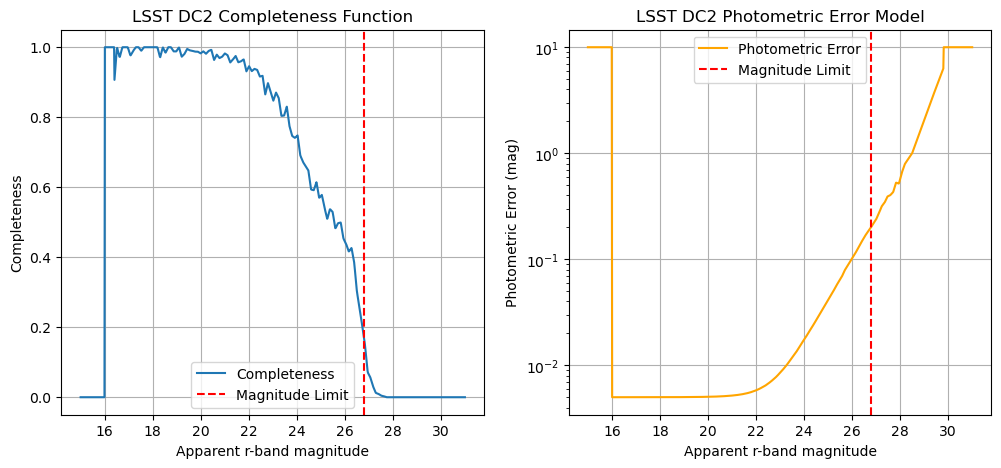

In [4]:
mag_r_test = np.linspace(15,31, 1000)
maglim_r_dc2 = 26.8
completeness_val = lsst_yr5.get_completeness('r', mag_r_test, maglim_r_dc2)
mag_error_val = lsst_yr5.get_photo_error('r', mag_r_test, maglim_r_dc2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(mag_r_test, completeness_val, label='Completeness')
ax[0].axvline(maglim_r_dc2, color='red', linestyle='--', label='Magnitude Limit')
ax[0].set_xlabel('Apparent r-band magnitude')
ax[0].set_ylabel('Completeness')
ax[0].set_title('LSST DC2 Completeness Function')
ax[0].grid()
ax[0].legend()  

ax[1].plot(mag_r_test, mag_error_val, label='Photometric Error', color='orange')
ax[1].axvline(maglim_r_dc2, color='red', linestyle='--', label='Magnitude Limit')
ax[1].set_yscale('log')
ax[1].set_xlabel('Apparent r-band magnitude')
ax[1].set_ylabel('Photometric Error (mag)')
ax[1].set_title('LSST DC2 Photometric Error Model')
ax[1].grid()
ax[1].legend()
plt.show()

### Cache manipulation
Once a survey has been loaded, it's stored in the cache. You can use commands to check which surveys are stored.
To force reloading of a survey, you must clear the cache first.

In [5]:
# Once a survey has been loaded once, it can be reused directly from the cache
lsst_yr1 = surveys.Survey.load(survey = 'lsst', release='yr5') # reuses the cached survey object

# Check the cache content

print("Current cache content: ", surveys.SurveyFactory.list_cached_surveys())

surveys.SurveyFactory.clear_cache(survey = 'lsst', release='yr5')
# surveys.SurveyFactory.clear_cache(survey = 'lsst') # to clear all releases of 'lsst'
# surveys.SurveyFactory.clear_cache() # to clear the entire cache
print("Cache content after clearing 'lsst': ", surveys.SurveyFactory.list_cached_surveys())

✓ Using cached survey data for 'lsst_yr5'
Current cache content:  ['lsst_yr5']
✓ Cleared cached survey 'lsst_yr5'
Cache content after clearing 'lsst':  []


## 2) Create an injector
The `StreamInjector` class wraps Survey objects and uses their properties to inject observational effects into a dataset.

In [6]:
# Create an injector using the Survey object
stream_injector = observed.StreamInjector(lsst_yr5)

# Or using survey name and release (this will create the survey object internally)
stream_injector = observed.StreamInjector(survey="lsst", release="yr5")

Loading survey data for 'lsst_yr5'...
  Loading config from: lsst_yr5.yaml

LOADING SURVEY DATA FILES
Survey data directory: /Users/pelissier/Documents/Codes/packages/stream_sim/stream_sim/../data/surveys/lsst_yr5

Fallback directory for shared data files: /Users/pelissier/Documents/Codes/packages/stream_sim/stream_sim/../data/others

Available bands: g, i, r, u, y, z

Loading magnitude limit maps...
  ✓ Success for g-band magnitude limit
  ⚠ Warning: 'maglim_map_i' not specified in config (skipping i-band)
  ✓ Success for r-band magnitude limit
  ⚠ Warning: 'maglim_map_u' not specified in config (skipping u-band)
  ⚠ Warning: 'maglim_map_y' not specified in config (skipping y-band)
  ⚠ Warning: 'maglim_map_z' not specified in config (skipping z-band)

Loading survey properties...

Loading completeness/efficiency function...
  Loading Completeness/efficiency function...
    File: stellar_efficiency_cutr.csv
    ✓ Success

Loading photometric error model...
  Loading Photometric error m

## 3) Inject different dataset types

To convert a stream catalog into realistic survey data, you need:
- Sky coordinates (ra, dec)
- True apparent magnitudes of the stars

However, **StreamSim** can **automatically sample these quantities** if they're missing, allowing incomplete datasets to be converted into realistic survey data.

StreamSim uses the magnitude limit at each star's location to estimate:
- The photometric error
- The observed magnitude
- Whether the object is detected and classified as a star

The output of the `inject()` method is a DataFrame containing:

- `ra`, `dec`: positions of the stream's stars on the sky
- `mag_{band}`: true apparent magnitude in a given band
- `mag_{band}_obs`: observed magnitude in a given band
- `magerr_{band}`: photometric error on the observed magnitude (in mag). Includes both systematic and statistical errors.
- `flag_observed`: 1 if the star has been detected by the survey and classified as a star. By default includes an SNR cut (SNR = 1/magerr > 5) in g and r bands.

The output can optionally include:
- `phi1`, `phi2`: position of stars in the stream frame
- `dist`: distance modulus of the stars

### Dataset with only (phi1, phi2) coordinates

If you only provide stream coordinates, StreamSim will:

**1. Sample apparent magnitudes:**

This is done using an isochrone and distance modulus model, which must be provided in a configuration dictionary. See `tutorial_generate_datamocks.ipynb` for more details.

**2. Convert (phi1, phi2) → (ra, dec):**

If you don't provide (ra, dec) columns, StreamSim will randomly place the stream on the sky. You can restrict the placement using the `mask_type` argument to ensure the stream falls within:
- The survey's footprint
- Regions with low dust extinction
- Areas meeting a minimum magnitude limit in a given band
- Any combination of the above

StreamSim searches uniformly across the sky for a reference frame where a specified fraction of the stream (`percentile_threshold`) lies inside the mask. For more details, see the documentation of the `StreamInjector._find_gc_frame()` method.

Alternatively, you can provide your own `gala.coordinates.GreatCircleICRSFrame` object via the `gc_frame` argument.

In [7]:
N = 1000
seed = 42

rng = np.random.default_rng(seed)

# Replace with your actual data
data_test = pd.DataFrame({
    'phi1': rng.uniform(-5, 5, N),
    'phi2': rng.uniform(-1, 1, N),
})


# Since our data set does not have magnitudes, we need to provide an isochrone and distance model - cf tutorial_generate_datamocks.ipynb
# This step can be skipped if the input data already has magnitudes in the desired bands

isochrone_config = {'isochrone':{'name': 'Bressan2012', # isochrone set name
                          'survey': 'lsst', # survey for filter set
                          'age': 12.0, # Age in Gyr of the population
                          'z': 0.0006, # Metallicity of the population
                          'band_1': 'g', # first band for color-magnitude
                          'band_2': 'r', # second band for color-magnitude
                          'band_1_detection': True},
}

distance_modulus_config = {'distance_modulus': {'center':  {'type': 'Constant', 'value': 16.5}, 
                                 'spread': {'type': 'Constant', 'value': 0.0}, 
                                }}

stream_config = {**isochrone_config, **distance_modulus_config}

In [8]:
mask_type = ['footprint', 'ebv'] # Restrict to survey footprint and apply extinction mask

# By default the bands used for detection are (g and r)
injected_data_full = stream_injector.inject(data_test, seed=seed, mask_type=mask_type, stream_config=stream_config, verbose=True)

Building new mask for ['ebv', 'footprint']...
  Resampling ebv from nside=512 to nside=128
✓ Mask created: valid pixels fraction = 0.5
  Cached with key: ('lsst', ('ebv', 'footprint'), 0.2)
Found suitable great circle frame after 2 trials with 100.00% points inside the mask.
Filled 1000 dist values.
Filled magnitudes for 1000 rows.
Applying detection cut on g band with SNR >= 5.0


/opt/anaconda3/envs/streamsim_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/streamsim_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
print(injected_data_full.columns)
injected_data_full.head()

Index(['phi1', 'phi2', 'ra', 'dec', 'dist', 'mag_g', 'mag_r', 'mag_r_obs',
       'magerr_r', 'mag_g_obs', 'magerr_g', 'flag_observed'],
      dtype='object')


,phi1,phi2,ra,dec,dist,mag_g,mag_r,mag_r_obs,magerr_r,mag_g_obs,magerr_g,flag_observed
0,2.739560,-0.875874,309.295394,-10.749590,16.5,28.192002,26.986330,27.099297481730773,0.326262,29.02992542147627,0.956891,False
1,-0.611216,-0.083476,310.268379,-14.058956,16.5,28.151158,26.952607,27.35713654431127,0.317125,27.025191525002626,1.073172,False
2,3.585979,-0.741940,308.757294,-10.075699,16.5,30.476255,28.869898,27.811982704422846,2.468415,BAD_MAG,10.000001,False
3,1.973680,-0.695347,309.516004,-11.506027,16.5,31.257963,29.543522,27.42904769794443,10.000001,BAD_MAG,10.000001,False
4,-4.058227,0.264566,311.724304,-17.227233,16.5,30.533566,28.918432,28.817729556146297,4.198281,28.99489763094307,10.000001,False


In [10]:
# If you want to work only with detected and classified stars
detected_data = injected_data_full[injected_data_full['flag_observed']]
print(len(detected_data), "stars detected out of", len(injected_data_full))

225 stars detected out of 1000


StreamSim has automatically sampled the missing columns (positions and apparent magnitudes) and estimated observational quantities.

You can verify the injection behavior with some useful plots:

(<Figure size 800x500 with 2 Axes>, <Axes: >)

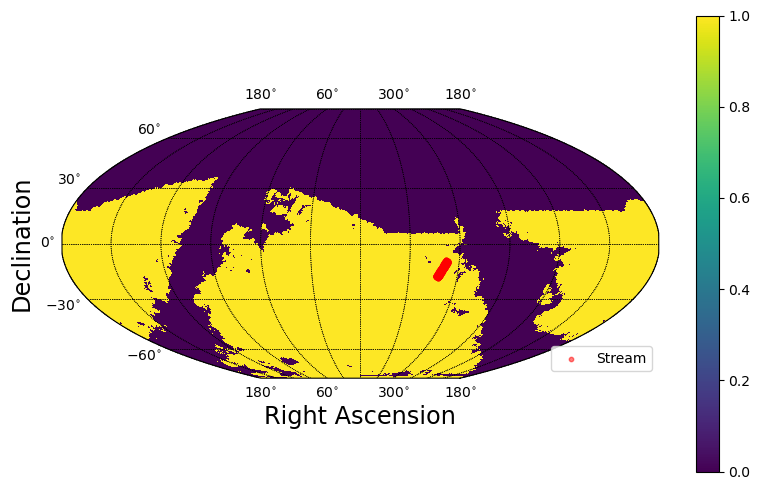

In [11]:
# Plot the injected stream in the survey mask
stream_injector.plot_stream_in_mask(injected_data_full, mask_type=mask_type)

The stream lies entirely within the chosen mask.

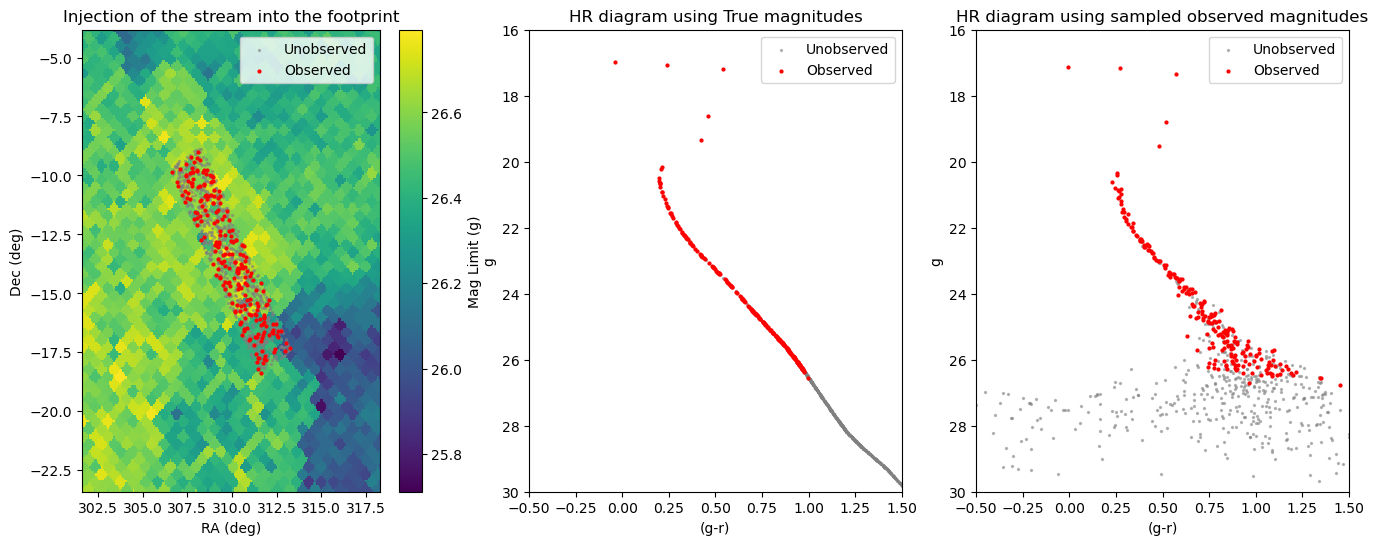

In [12]:
from stream_sim.plotting import plot_inject

# Plot results
fig, ax = plot_inject(injected_data_full, lsst_yr5, bands=['g', 'r'], save=False)
plt.show()

### Dataset containing (ra, dec) coordinates and distance modulus

StreamSim only needs to sample the missing magnitudes, so you must provide a configuration dictionary for the isochrone model.

In [13]:
# Let's build a data set containing only (ra, dec) coordinates
data_set_radec = injected_data_full.drop(columns=[col for col in injected_data_full.columns if col not in ['ra', 'dec', 'dist']])
data_set_radec.head()

,ra,dec,dist
0,309.295394,-10.749590,16.5
1,310.268379,-14.058956,16.5
2,308.757294,-10.075699,16.5
3,309.516004,-11.506027,16.5
4,311.724304,-17.227233,16.5


In [14]:
injected_data = stream_injector.inject(data_set_radec, seed=seed, mask_type=None, stream_config=isochrone_config, verbose=True)
injected_data.head()

Filled magnitudes for 1000 rows.
Applying detection cut on g band with SNR >= 5.0


/opt/anaconda3/envs/streamsim_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/streamsim_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ra,dec,dist,mag_g,mag_r,mag_r_obs,magerr_r,mag_g_obs,magerr_g,flag_observed
0,309.295394,-10.749590,16.5,28.176648,26.973654,26.986784595333763,0.323451,28.011676334204818,0.945682,False
1,310.268379,-14.058956,16.5,27.584545,26.457709,26.774227785816738,0.193933,27.45192532455089,0.551862,False
2,308.757294,-10.075699,16.5,28.645651,27.360886,27.225238763821874,0.408955,28.428164752105715,2.145464,False
3,309.516004,-11.506027,16.5,23.900236,23.293602,23.44646116512147,0.013246,24.11444654404552,0.022097,True
4,311.724304,-17.227233,16.5,26.170663,25.217478,25.547347795122825,0.086613,26.36150205957524,0.199014,True


### Dataset containing (ra, dec) and true apparent magnitudes

The dataset already contains all the required quantities, so you don't need to provide a configuration dictionary or mask type.

In [15]:
# Let's build a dataset containing (ra, dec) coordinates and magnitudes
data_set_radecmag = injected_data_full.drop(columns=[col for col in injected_data_full.columns if col not in ['ra', 'dec', 'mag_r', 'mag_g']])
data_set_radecmag.head()

,ra,dec,mag_g,mag_r
0,309.295394,-10.749590,28.192002,26.986330
1,310.268379,-14.058956,28.151158,26.952607
2,308.757294,-10.075699,30.476255,28.869898
3,309.516004,-11.506027,31.257963,29.543522
4,311.724304,-17.227233,30.533566,28.918432


In [16]:
injected_data = stream_injector.inject(data_set_radecmag, seed=seed, mask_type=None, stream_config=None, verbose=True)
injected_data.head()

Applying detection cut on g band with SNR >= 5.0


/opt/anaconda3/envs/streamsim_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/streamsim_dev/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ra,dec,mag_g,mag_r,mag_r_obs,magerr_r,mag_g_obs,magerr_g,flag_observed
0,309.295394,-10.749590,28.192002,26.986330,26.998676119969865,0.326262,28.023766591992654,0.956891,False
1,310.268379,-14.058956,28.151158,26.952607,27.43911060376833,0.317125,27.81606237588198,1.073172,False
2,308.757294,-10.075699,30.476255,28.869898,27.92365647714289,2.468415,29.42785873330589,10.000001,False
3,309.516004,-11.506027,31.257963,29.543522,27.2459979804351,10.000001,29.005352370811487,10.000001,False
4,311.724304,-17.227233,30.533566,28.918432,BAD_MAG,4.198281,30.097982260803143,10.000001,False


## 4) Usage example

This can be useful for comparing analysis results between the ideal case of dynamic simulations and the more realistic case of observed data.

For example, we can calculate the 1D density along the stream and its power spectrum.

In [17]:
def plot_power_spectrum(data, fig=None, ax=None, phi1_bin_edges=None, label=None):
    """Plot 1D density along phi1 and its power spectrum."""
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Compute 1D density along phi1
    phi1 = np.array(data['phi1'])
    if phi1_bin_edges is None:
        phi1_bin_edges = np.linspace(np.min(phi1), np.max(phi1), 50)
    counts, _ = np.histogram(phi1, bins=phi1_bin_edges)
    bin_centers = 0.5 * (phi1_bin_edges[:-1] + phi1_bin_edges[1:])

    # Compute power spectrum using cross-spectral density method from scipy
    from scipy.signal import csd
    fs = 1.0 / (bin_centers[1] - bin_centers[0])  # Sampling frequency
    k, Pxx = csd(counts, counts, nperseg=len(counts), fs=fs)

    # Plot density
    ax[0].plot(bin_centers, counts, drawstyle='steps-mid', label=label)
    ax[0].set_xlabel('phi1 (deg)')
    ax[0].set_ylabel('Star counts')
    ax[0].set_title('1D Density along phi1')

    # Plot power spectrum (1/k, P(k)) in log-log scale
    ax[1].loglog(1/k, Pxx, label=label)
    ax[1].set_xlabel('1/k (deg)')
    ax[1].set_ylabel('P(k)')
    ax[1].set_title('Power Spectrum of 1D Density')

    for a in ax.flatten():
        a.grid()
        if label is not None:
            a.legend()
    return fig, ax

/var/folders/9j/zk4h50g505d635j69p9tgwbc0000gp/T/ipykernel_25449/3483219967.py:25: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/k, Pxx, label=label)


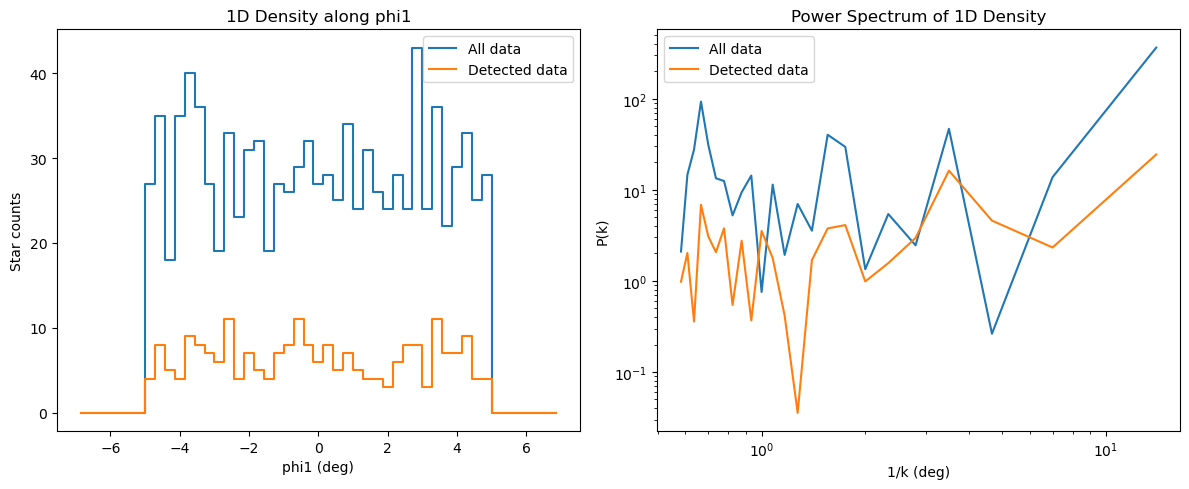

In [18]:
# Compare the power spectrum of all stars vs. detected stars only
phi1_bin_edges = np.linspace(-7, 7, 50)
fig, ax = plot_power_spectrum(injected_data_full, label='All data', phi1_bin_edges=phi1_bin_edges)
fig, ax = plot_power_spectrum(injected_data_full[injected_data_full['flag_observed']], fig=fig, ax=ax, label='Detected data', phi1_bin_edges=phi1_bin_edges)
fig.tight_layout()

## 5) Conclusion

StreamSim provides a method for converting data mocks into realistic observed data for a given survey, with minimal computational cost. This can be easily achieved with just a few commands, helping to bridge the gap between simulations and observational challenges in the field of stellar streams.


You can find more informations in the [full documentation](https://lsstdesc.github.io/stream_sim/).